In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [3]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03,sigma=0.2)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios,mu=0.07,sigma=0.15)

In [4]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='EQ', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75)
], axis=1).round(2)

,ZC,EQ,70/30
mean,1.23,1.98,1.75
std,0.00,1.01,0.61
p_breach,NaN,0.03,0.01
e_short,NaN,0.13,0.09
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [5]:
# Let's try to solve these breaches.
# Allocator right now does not take into account the floor. So let's fix this
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    '''
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP.
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    '''
    if zc_prices.shape != psp_r.shape:
        raise ValueError('PSP and ZC Prices must have the same shape')
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step]
        cushion = (account_value-floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) #same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc=account_value*ghp_w
        # Recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [7]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:])
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='EQ', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
    erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75)
], axis=1).round(2)

,ZC,EQ,70/30,Floor75
mean,1.23,1.98,1.75,1.97
std,0.00,1.01,0.61,1.00
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.13,0.09,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [9]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='EQ', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
    erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75),
    erk.terminal_stats(rets_floor75m1, name='Floor75 M1', floor=0.75),
    erk.terminal_stats(rets_floor75m5, name='Floor75 M5', floor=0.75)
], axis=1).round(2)

,ZC,EQ,70/30,Floor75,Floor75 M1,Floor75 M5
mean,1.23,1.98,1.75,1.97,1.69,1.97
std,0.00,1.01,0.61,1.00,0.47,1.01
p_breach,NaN,0.03,0.01,NaN,NaN,0.00
e_short,NaN,0.13,0.09,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='EQ', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
    erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75),
    erk.terminal_stats(rets_floor75m1, name='Floor75 M1', floor=0.75),
    erk.terminal_stats(rets_floor75m5, name='Floor75 M5', floor=0.75)
], axis=1).round(4)

,ZC,EQ,70/30,Floor75,Floor75 M1,Floor75 M5
mean,1.2349,1.9756,1.7535,1.9658,1.6853,1.9658
std,0.0000,1.0051,0.6057,0.9982,0.4671,1.0065
p_breach,NaN,0.0314,0.0078,NaN,NaN,0.0004
e_short,NaN,0.1286,0.0882,NaN,NaN,0.0021
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


# Risk Budgeting with Drawdown Constraints

In [12]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name='ZC', floor=0.75),
    erk.terminal_stats(rets_eq, name='EQ', floor=0.75),
    erk.terminal_stats(rets_7030b, name='70/30', floor=0.75),
    erk.terminal_stats(rets_floor75, name='Floor75', floor=0.75),
    erk.terminal_stats(rets_floor75m1, name='Floor75 M1', floor=0.75),
    erk.terminal_stats(rets_floor75m5, name='Floor75 M5', floor=0.75),
    erk.terminal_stats(rets_maxdd25, name='MaxDrawdown 0.25', floor=0.75)
], axis=1).round(4)

,ZC,EQ,70/30,Floor75,Floor75 M1,Floor75 M5,MaxDrawdown 0.25
mean,1.2349,1.9756,1.7535,1.9658,1.6853,1.9658,1.6327
std,0.0000,1.0051,0.6057,0.9982,0.4671,1.0065,0.5510
p_breach,NaN,0.0314,0.0078,NaN,NaN,0.0004,NaN
e_short,NaN,0.1286,0.0882,NaN,NaN,0.0021,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].head()

0   -0.172984
1   -0.161977
2   -0.160800
3   -0.194885
4   -0.124138
Name: Max Drawdown, dtype: float64

In [14]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].min()

-0.23619544051435842

C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mikael\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

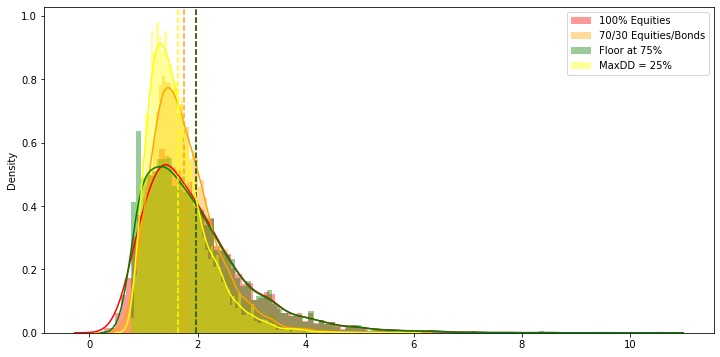

In [17]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color='red', label='100% Equities', bins=100)
plt.axvline(tv_eq.mean(), ls='--', color='red')
sns.distplot(tv_7030b, color='orange', label='70/30 Equities/Bonds', bins=100)
plt.axvline(tv_7030b.mean(), ls='--', color='orange')
sns.distplot(tv_floor75, color='green', label='Floor at 75%', bins=100)
plt.axvline(tv_floor75.mean(), ls='--', color='green')
sns.distplot(tv_maxdd25, color='yellow', label='MaxDD = 25%', bins=100)
plt.axvline(tv_maxdd25.mean(), ls='--', color='yellow')
plt.legend();

# Drawdown constraint with historical data

<AxesSubplot:>

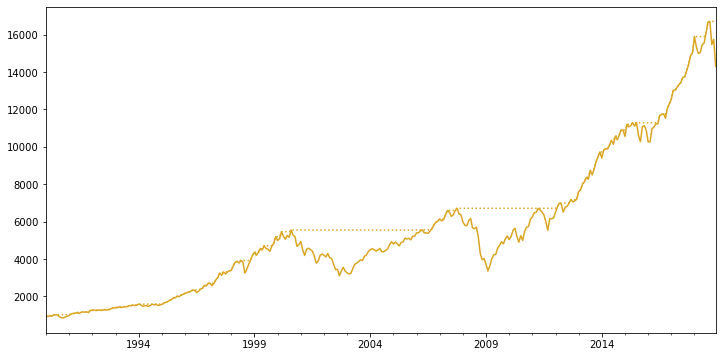

In [20]:
rets_tmi = erk.get_total_market_index_returns()['1990':]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi['Wealth'].plot(figsize=(12,6), ls='-', color='goldenrod')
dd_tmi['Peaks'].plot(ax=ax, ls=':', color='goldenrod')

<AxesSubplot:>

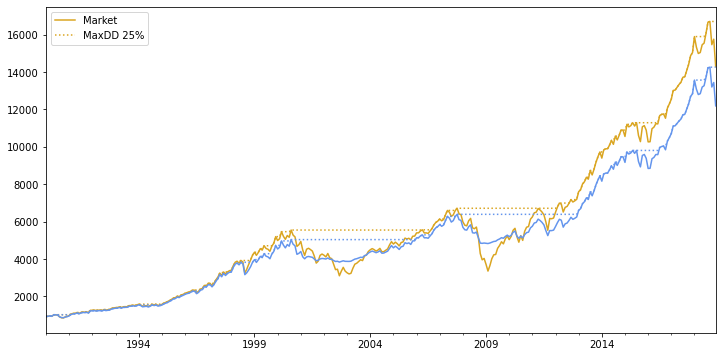

In [27]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column DataFrame
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi['Wealth'].plot(figsize=(12,6), ls='-', color='goldenrod', label='Market', legend=True)
dd_tmi['Peaks'].plot(ax=ax, ls=':', color='goldenrod')
dd_25['Wealth'].plot(ax=ax, label='MaxDD 25%', legend=True, color='cornflowerblue')
dd_25['Peaks'].plot(ax=ax, color='cornflowerblue', ls=':')